In [1]:
%matplotlib widget

import twixtools
from pygrappa import grappa

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

from pylab import *
from matplotlib.widgets import LassoSelector
from mpl_interactions import image_segmenter

example_dir = '../example_data'

def ifftnd(kspace, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, ifftn
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, fftn
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

def phase_comb(sig, axis=1):
    return np.angle(np.sum(sig, axis))

In [5]:
# parse the twix files

## TR 1000
twix_pre_noimp = twixtools.read_twix('meas_MID00930_FID96760_t1_gradient_echo_TR1000_baseline.dat')
twix_post_noimp = twixtools.read_twix('meas_MID00938_FID96768_t1_gradient_echo_TR1000_postexposure.dat')

twix_pre = twixtools.read_twix('meas_MID00939_FID96769_t1_gradient_echo_TR1000_baseline.dat')
twix_post = twixtools.read_twix('meas_MID00943_FID96773_t1_gradient_echo_TR1000_postexposure.dat')

# ## TR 250
# twix_pre_noimp = twixtools.read_twix('meas_MID00931_FID96761_t1_gradient_echo_TR250_baseline.dat')
# twix_post_noimp = twixtools.read_twix('meas_MID00937_FID96767_t1_gradient_echo_TR250_postexposure.dat')

# twix_pre_noimp = twixtools.read_twix('meas_MID00940_FID96770_t1_gradient_echo_TR250_baseline.dat')
# twix_post_noimp = twixtools.read_twix('meas_MID00942_FID96772_t1_gradient_echo_TR250_postexposure.dat')

# twix is a list of measurements:
print('\nnumber of separate scans (multi-raid):', len(twix_pre_noimp))

Software version: VD/VE (!?)

Scan  0


100%|██████████████████████████████████████████████████████████████████████████████| 9.16M/9.16M [00:00<00:00, 82.5MB/s]


Scan  1


100%|███████████████████████████████████████████████████████████████████████████████| 11.2M/11.2M [00:00<00:00, 443MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 9.16M/9.16M [00:00<00:00, 148MB/s]


Scan  1


100%|███████████████████████████████████████████████████████████████████████████████| 11.2M/11.2M [00:00<00:00, 437MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 9.16M/9.16M [00:00<00:00, 123MB/s]


Scan  1


100%|███████████████████████████████████████████████████████████████████████████████| 11.2M/11.2M [00:00<00:00, 463MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 9.16M/9.16M [00:00<00:00, 152MB/s]


Scan  1


100%|███████████████████████████████████████████████████████████████████████████████| 11.2M/11.2M [00:00<00:00, 329MB/s]


number of separate scans (multi-raid): 2


In [50]:
# Now do it all again for pre/post and abbreviate code 
def get_grappa_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    cal_data = mapped[-1]['refscan']
    im_data.flags['remove_os'] = False

    data = im_data[:].squeeze()
    data_cal = cal_data[:].squeeze()
    print(data.shape, data_cal.shape)

    res = np.empty_like(data)
    for slice in np.arange(data.shape[slice_axis]):
        for contrast in np.arange(data.shape[contrast_axis]):
            data_contrast = data[slice, contrast,:,:,:]
            data_cal_contrast = data_cal[slice, contrast,22:46,:,:]
            print(data_cal_contrast.shape, data_contrast.shape)
            res[slice, contrast,:,:,:] = grappa(data_contrast, data_cal_contrast, coil_axis=1, silent=True)
    print(res.shape)
    return res

def get_image_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    im_data.flags['remove_os'] = False
    data = im_data[:].squeeze()
    print(data.shape)

    return data

slice_axis = 0
contrast_axis = 1
coil_axis = 3

# Summation approach to combine coils
res_pre = np.sum(get_grappa_kspace(twix_pre), coil_axis)
res_post = np.sum(get_grappa_kspace(twix_post), coil_axis)

# # Select single coil that gives best signal
# res_pre = get_grappa_kspace(twix_pre)[:,:,:,1,:]
# res_post = get_grappa_kspace(twix_post)[:,:,:,1,:]

print(res_pre.shape)

image_pre = ifftnd(res_pre, [2,-1])
image_rms_pre = rms_comb(image_pre)
phase_img_pre = np.angle(image_pre)
phase_img_comb_pre = phase_comb(image_pre)

image_post = ifftnd(res_post, [2,-1])
image_rms_post = rms_comb(image_post)
phase_img_post = np.angle(image_post)
phase_img_comb_post = phase_comb(image_post)

(4, 4, 63, 4, 512) (4, 4, 44, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(4, 4, 63, 4, 512)
(4, 4, 63, 4, 512) (4, 4, 44, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(22, 4, 512) (63, 4, 512)
(4, 4, 63, 4, 512)
(4, 4, 63, 512)


(4, 4, 63, 512)


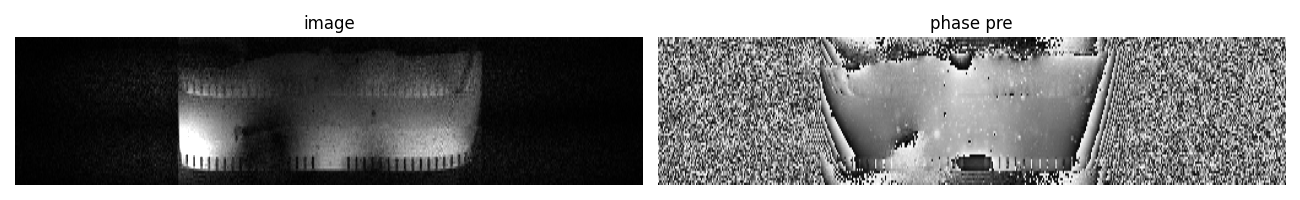

In [58]:
## Check kspace 
print(res_pre.shape)
plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_pre[0,3,:,:]), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase pre')
plt.imshow(phase_img_pre[2,0,:,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

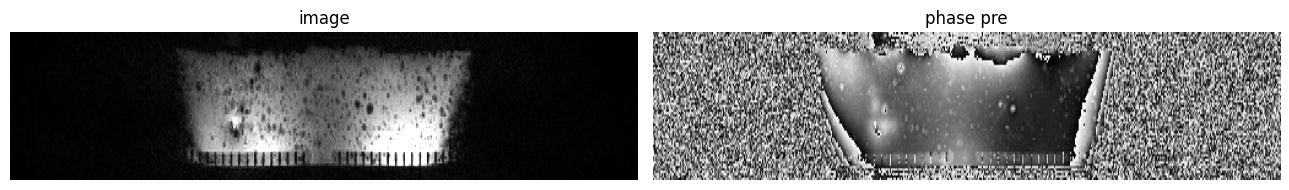

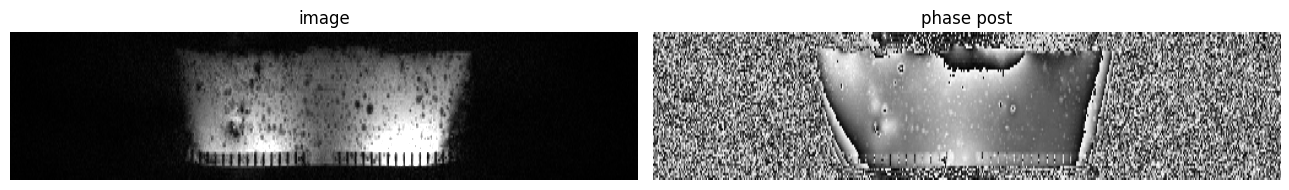

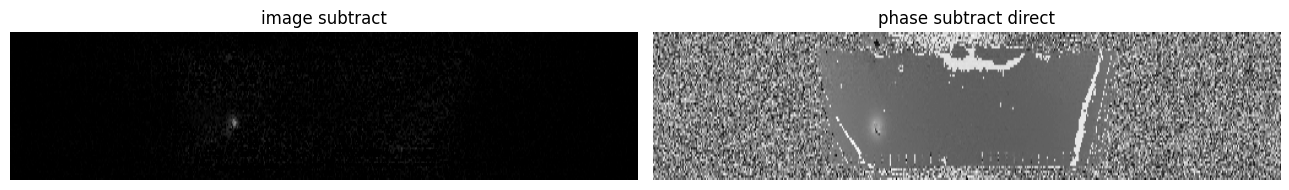

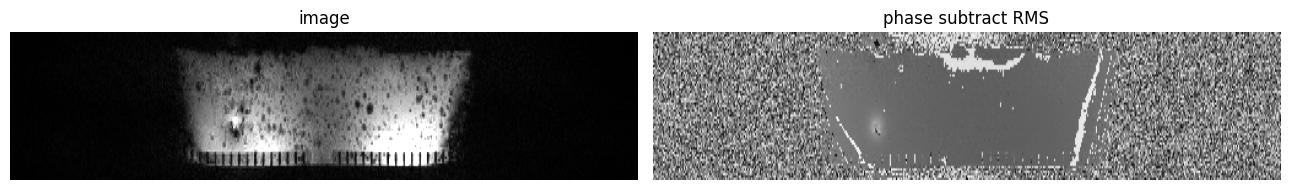

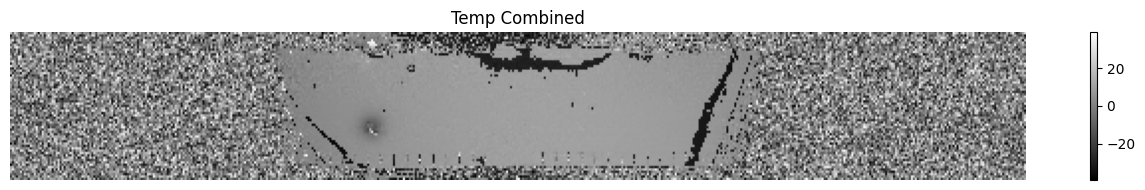

In [107]:
#Select ROI
%matplotlib inline

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_pre), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase pre')
plt.imshow(phase_img_pre, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_post), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase post')
plt.imshow(phase_img_post, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image subtract')
plt.imshow(abs(image_pre) - abs(image_post), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase subtract direct')
plt.imshow(phase_img_pre - phase_img_post, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_pre), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase subtract RMS')
plt.imshow(phase_img_pre - phase_img_post, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()
    
# Calculate temperature map
alpha = 0.01e-6 #ppm/C
gyromagnetic_ratio = 267.522e6 #rad/s/T
B0 = 1.494 #T
TE = 0.040 #s
phase_sub_complex = np.angle(np.multiply(image_post,image_pre))
phase_sub_comb = phase_img_post - phase_img_pre
temp_map_comb = (phase_img_post - phase_img_pre) / (alpha*gyromagnetic_ratio*B0*TE)
# temp_map_comb = (phase_sub_complex) / (alpha*gyromagnetic_ratio*B0*TE)

plt.figure(figsize=[13,2])
plt.title('Temp Combined')
plt.imshow(temp_map_comb, cmap='gray', origin='lower', aspect='auto')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

plt.close()

(63, 512)


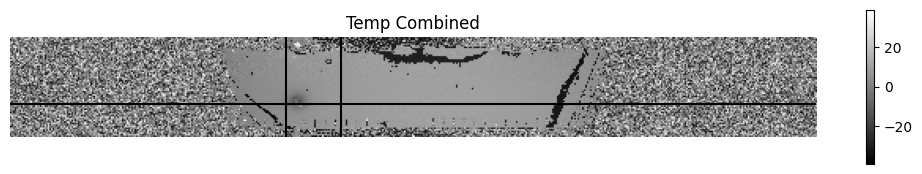

(25,)


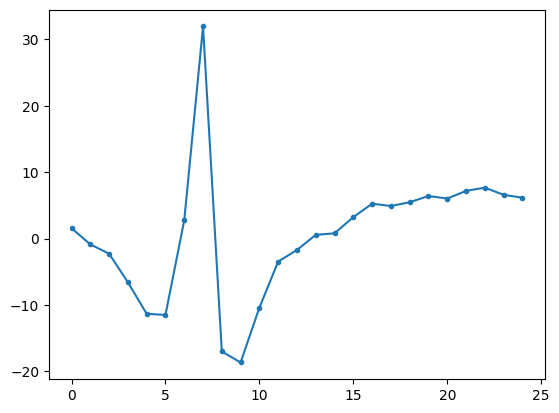

In [114]:
plt.figure(figsize=[13,2])
plt.title('Temp Combined')
print(temp_map_comb.shape)
plt.plot([0,512],[20,20], 'k-')
plt.plot([175,175],[0,63], 'k-')
plt.plot([210,210],[0,63], 'k-')
plt.imshow(temp_map_comb, cmap='gray', origin='lower')
plt.colorbar()
plt.axis('off')
#plt.tight_layout()
plt.show()

fig = plt.figure()
print(temp_map_comb[20,175:200].flatten().shape)
plt.plot(temp_map_comb[20,175:200], '.-')
plt.show()

In [124]:
# Now do it all again for pre/post and abbreviate code 
def get_grappa_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    cal_data = mapped[-1]['refscan']
    im_data.flags['remove_os'] = False

    data = im_data[:].squeeze()
    print(data.shape)
    data = data[0,3,:,:,:]    
    data_cal = cal_data[:].squeeze()
    print(data_cal.shape)
    data_cal = data_cal[0,3,22:46,:,:]

    res = grappa(data, data_cal, coil_axis=1, silent=False)
    return res

def get_image_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    im_data.flags['remove_os'] = False
    data = im_data[:].squeeze()
    print(data.shape)

    return data

res_pre = np.sum(get_grappa_kspace(twix_pre_noimp),1)
res_post = np.sum(get_grappa_kspace(twix_post_noimp),1)

image_pre = ifftnd(res_pre, [0,-1])
image_rms_pre = rms_comb(image_pre)
phase_img_pre = np.angle(image_pre)
phase_img_comb_pre = phase_comb(image_pre)

image_post = ifftnd(res_post, [0,-1])
image_rms_post = rms_comb(image_post)
phase_img_post = np.angle(image_post)
phase_img_comb_post = phase_comb(image_post)


(4, 4, 63, 8, 512)
(4, 4, 44, 8, 512)
P took 0.327422 seconds!
A took 0.010473 seconds
Training and application of weights took 0.486025seconds
(4, 4, 63, 8, 512)
(4, 4, 44, 8, 512)
P took 0.385001 seconds!
A took 0.00846815 seconds
Training and application of weights took 0.452012seconds


(63, 512)


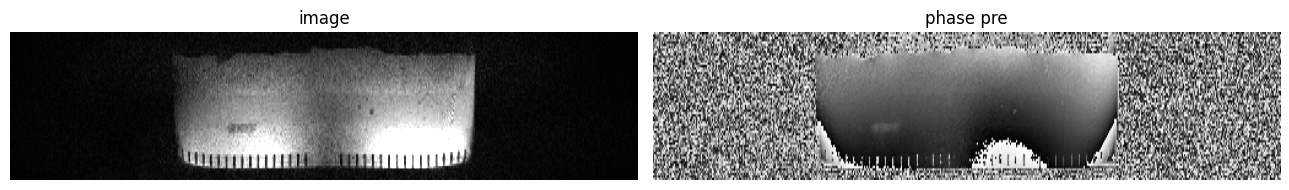

In [126]:
## Check kspace 
print(res_pre.shape)
plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_pre), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase pre')
plt.imshow(phase_img_pre, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

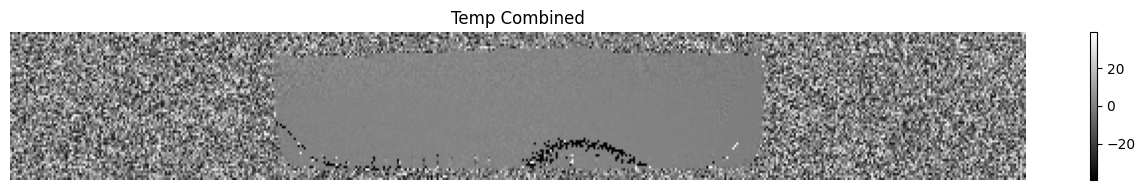

(63, 512)


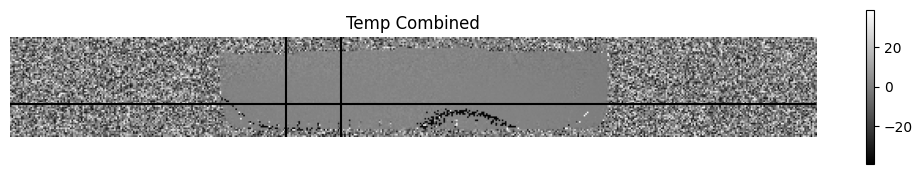

(45,)


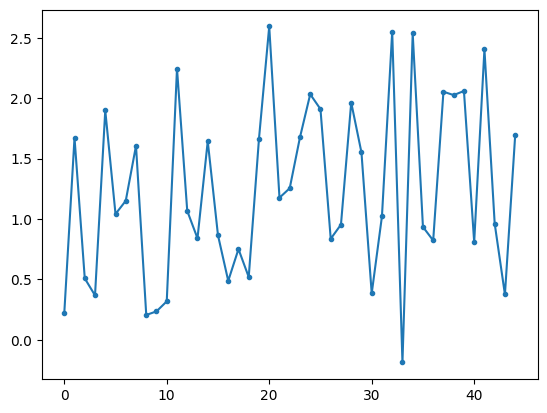

In [129]:
# Calculate temperature map
alpha = 0.01e-6 #ppm/C
gyromagnetic_ratio = 267.522e6 #rad/s/T
B0 = 1.494 #T
TE = 0.040 #s
phase_sub_complex = np.angle(np.multiply(image_post,image_pre))
phase_sub_comb = phase_img_post - phase_img_pre
temp_map_comb = (phase_img_post - phase_img_pre) / (alpha*gyromagnetic_ratio*B0*TE)
# temp_map_comb = (phase_sub_complex) / (alpha*gyromagnetic_ratio*B0*TE)

plt.figure(figsize=[13,2])
plt.title('Temp Combined')
plt.imshow(temp_map_comb, cmap='gray', origin='lower', aspect='auto')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.title('Temp Combined')
print(temp_map_comb.shape)
plt.plot([0,512],[20,20], 'k-')
plt.plot([175,175],[0,63], 'k-')
plt.plot([210,210],[0,63], 'k-')
plt.imshow(temp_map_comb, cmap='gray', origin='lower')
plt.colorbar()
plt.axis('off')
#plt.tight_layout()
plt.show()

fig = plt.figure()
print(temp_map_comb[20,155:200].flatten().shape)
plt.plot(temp_map_comb[20,155:200], '.-')
plt.show()

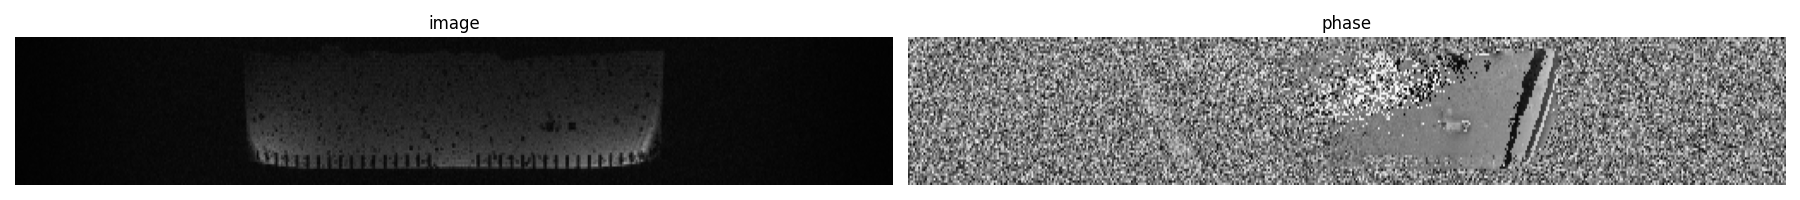

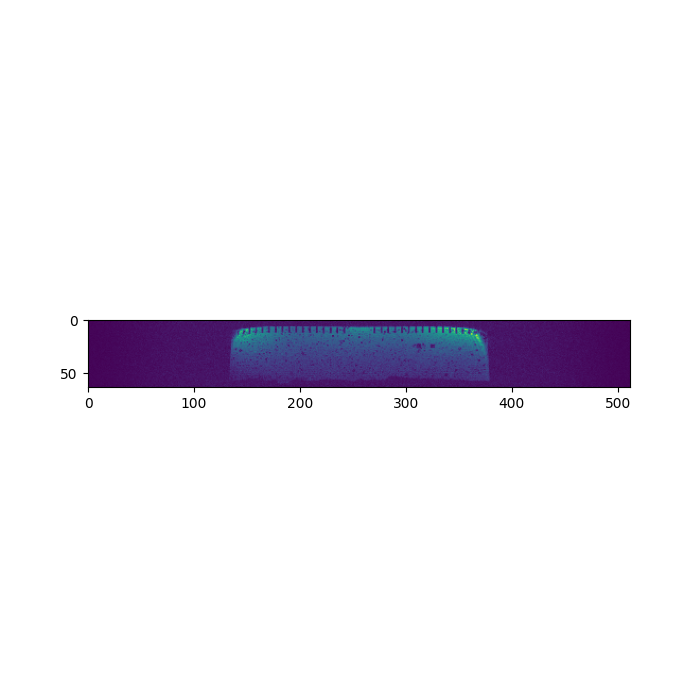

In [29]:
# Now get ROI specific information


def onselect(verts):
    print(verts)

%matplotlib ipympl

fig = plt.figure(figsize=[12,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_post), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

ax = plt.subplot(122)
plt.title('phase')
ax.imshow(phase_img_pre[:,0,:] - phase_img_post[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

segmenter = image_segmenter(abs(image_rms_post), mask_colors='red', mask_alpha=0.76, figsize=(7, 7))
display(segmenter)


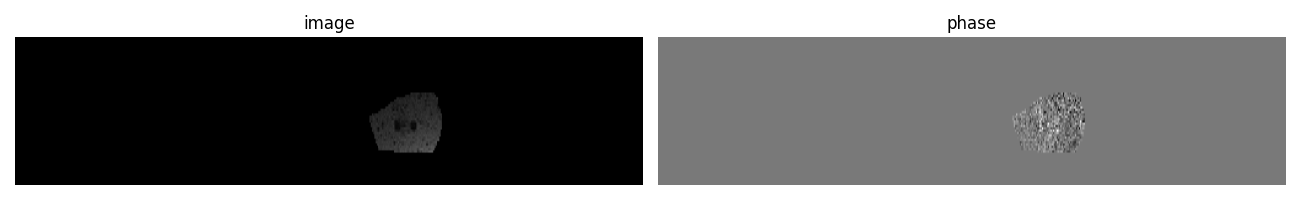

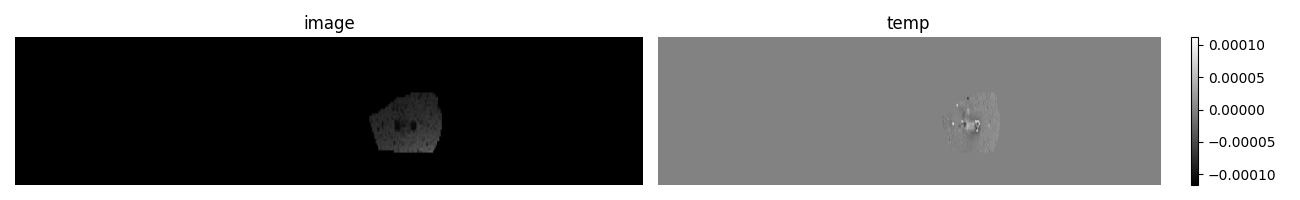

In [38]:
%matplotlib widget

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre) * segmenter.mask, cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase')
plt.imshow((phase_img_rms_pre - phase_img_rms_post) * segmenter.mask, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre) * segmenter.mask, cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('temp')
plt.imshow(temp_map * segmenter.mask, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.colorbar()
plt.show()

NameError: name 'res' is not defined

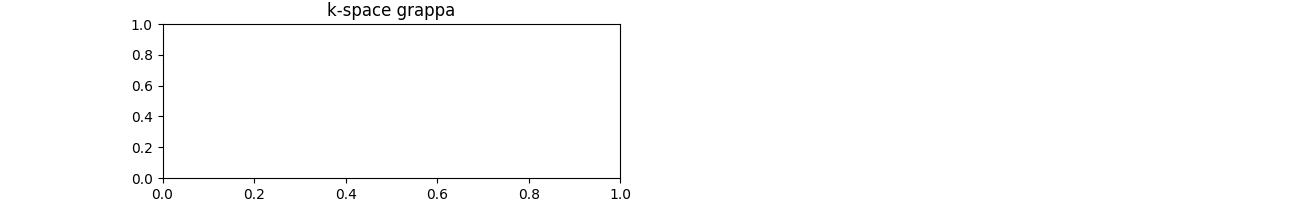

In [31]:
for channel in range(4):

    plt.figure(figsize=[13,2])
    plt.subplot(121)
    plt.title('k-space grappa')
    plt.imshow(abs(res[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

    plt.subplot(122)
    plt.title('k-space original')
    plt.imshow(abs(data[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

plt.figure(figsize=[13,2])
image = ifftnd(res, [0,-1])
image_rms = rms_comb(image)
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

phase_img = np.angle(image)
phase_img_rms = rms_comb(phase_img)
plt.subplot(122)
plt.title('phase')
plt.imshow(phase_img[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
    
plt.tight_layout()

print(np.max(phase_img))

In [11]:
# Now make phase map for pre/post



In [12]:
twix = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00895_FID92050_t1_gradient_echo_tra.dat'), keep_syncdata_and_acqend=True)
mapped = twixtools.map_twix(twix[-1])

         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 7.03M/7.03M [00:00<00:00, 372MB/s]


In [13]:
data = mapped['image'][0,0,0,0,0,0,0,0].squeeze()
print(data.shape)

(10, 63, 4, 512)
